In [1]:
import torch as T
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# ds_tr = datasets.MNIST('./', train=True, download=True)
ds_tr = datasets.MNIST('./', train=True)
ds_ts = datasets.MNIST('./', train=False)

print(len(ds_tr), len(ds_ts))

60000 10000



torch.Size([50]) torch.Size([50, 28, 28]) torch.Size([50])


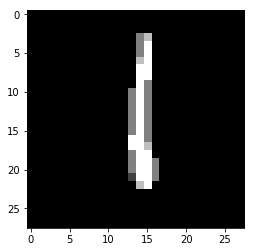

tensor(1)


In [2]:
import numpy as np
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
%matplotlib inline

class MNIST(Dataset):
    def __init__(self, ds):
        super().__init__()
        
        self.dat = []
        
        for img, lbl in tqdm(ds):
            img = np.asarray(img).astype(np.float32) / 255.0
            
            self.dat.append([img, lbl])
    
    def __len__(self):
        return len(self.dat)
    
    def __getitem__(self, idx):
        img, lbl = self.dat[idx]
        
        return idx, img, lbl

ld_tr = DataLoader(MNIST(ds_tr), batch_size=50, shuffle=True)
ld_ts = DataLoader(MNIST(ds_ts), batch_size=100)

for idx, img, lbl in ld_tr:
    print(idx.shape, img.shape, lbl.shape)
    
    plt.figure()
    plt.imshow(ds_tr[idx[0]][0])
    plt.show()
    plt.close()
    
    print(lbl[0])
    
    break

In [3]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc = nn.Sequential(nn.Linear(28**2, 10**2), nn.ReLU(), 
                                nn.Linear(10**2, 10**2), nn.ReLU(), 
                                nn.Linear(10**2, 10))
    
    def forward(self, img):
        img = img.view((img.shape[0], -1))
        
        out = self.fc(img)
        
        return out

model = Model().cuda()
print(model)

out = model(img.cuda())
print(out.shape)

Model(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)
torch.Size([50, 10])


In [4]:
EPOCHS = 10
LR = 0.002

loss_ce = nn.CrossEntropyLoss().cuda()
optim = T.optim.Adam(model.parameters(), lr=LR)

In [5]:
for e in tqdm(range(EPOCHS)):
    ls_ep = 0
    
    with tqdm(ld_tr) as TQ:
        for _, img, lbl in TQ:
            out = model(img.cuda())
            
            ls_bh = loss_ce(out, lbl.cuda())
            
            optim.zero_grad()
            ls_bh.backward()
            optim.step()
            
            ls_bh = ls_bh.detach().cpu().numpy()
            ls_ep += ls_bh
            
            TQ.set_postfix(ls_bh='%.3f'%(ls_bh))
        
        ls_ep /= len(TQ)
        print('Ep %d: %.4f' % (e+1, ls_ep))
    
    acc_ep = 0
    with tqdm(ld_ts) as TQ:
        for _, img, lbl in TQ:
            out = model(img.cuda())
            
            out = np.argmax(out.detach().cpu().numpy(), axis=1)
            lbl = lbl.numpy()
            
            acc_bh = np.average(out==lbl)
            acc_ep += acc_bh
            
            TQ.set_postfix(acc_bh='%.3f%%'%(acc_bh*100))
        
        acc_ep /= len(TQ)
        print('Test: %.4f%%'%(acc_ep*100))

Ep 1: 0.2641


Test: 95.9400%


Ep 2: 0.1072


Test: 96.8300%


Ep 3: 0.0768


Test: 97.3800%


Ep 4: 0.0604


Test: 96.9700%


Ep 5: 0.0518


Test: 97.4000%


Ep 6: 0.0412


Test: 97.5700%


Ep 7: 0.0360


Test: 97.5100%


Ep 8: 0.0317


Test: 97.6700%


Ep 9: 0.0273


Test: 97.4400%


Ep 10: 0.0262


Test: 97.4900%

